In [1]:
from transformers import AutoConfig, AutoModelForCausalLM
# from transformers import MistralForCausalLM
# from fast_llm.models.ssm.external.apriel_15b_hybrid.configuration_ssm_hybrid_apriel15b import AprielSSMHybridConfig
# from fast_llm.models.ssm.external.apriel_15b_hybrid.modeling_ssm_hybrid_apriel15b import AprielSSMHybridForCausalLM
# autoreload changes to the code
%reload_ext autoreload
%autoreload 2


/home/toolkit/.local/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# model_path = "/mnt/checkpoints/fast_llm_exp/slam_ssm_distill/15bch-ifrhyb20l32h-bs768-lr0.0003-lrs0-0-0-0-sl4096_ti1000_lm2/export/apriel_ssm_thinker_hybrid/1000"
# AutoConfig.from_pretrained(model_path, trust_remote_code=True)

In [3]:
# model_path = "/mnt/checkpoints/fast_llm_exp/slam_ssm_distill/15bch-ifrhyb20l32h-bs768-lr0.0003-lrs0-0-0-0-sl4096_ti1000_lm2/export/apriel_ssm_thinker_hybrid/1000"
# m = AutoModelForCausalLM.from_pretrained(
#     model_path, trust_remote_code=True,
#     config=AutoConfig.from_pretrained(model_path, trust_remote_code=True),
# )

### Slam 15B upcycled

 Lead the weights of https://huggingface.co/ServiceNow-AI/Slam-15B-Upcycled/ into Thiked modeling, it shoudl work

In [2]:
import sys
sys.path.append("/home/toolkit/dev/fml-ops/__oo_playground")
from results_analysis.results_loader import ResultsLoader
layer_importance_path = "/mnt/evaluations/training_evaluation/model_runs/lm_eval_runner/apriel_ssm_importance/"
results_loader = ResultsLoader(layer_importance_path)

results_loader.deserialize_results()
results_df = results_loader.to_df()
results_df["layer_index"] = results_df.apply(lambda row: int(row["model_name_sanitized"].split("_")[-1] if "layers_" in row["model_name_sanitized"] else -1), axis=1)
results_df = results_df[results_df["metric"] == "acc_norm"]
columns_to_keep = ["layer_index", "metric_value"]
results_df = results_df[columns_to_keep]
layer_importance = results_df.groupby("layer_index").mean()
layer_importance = layer_importance.sort_values(by="metric_value", ascending=False).reset_index()
layer_importance = layer_importance[layer_importance["layer_index"]!= -1]
layer_importance = list(layer_importance["layer_index"])

In [3]:
layer_importance

[22,
 25,
 20,
 31,
 29,
 46,
 23,
 26,
 33,
 24,
 47,
 27,
 21,
 41,
 17,
 18,
 34,
 42,
 44,
 30,
 16,
 8,
 43,
 35,
 19,
 38,
 15,
 28,
 32,
 45,
 37,
 40,
 7,
 36,
 13,
 10,
 5,
 39,
 6,
 14,
 4,
 12,
 9,
 48,
 1,
 3,
 11,
 49,
 0]

In [4]:
path_thinker = "/mnt/checkpoints/upstream/Apriel-Nemotron-15b-Thinker"
n_ssm = 25

config_thinker = AutoConfig.from_pretrained(path_thinker)
hybrid_block_layout = ["t"] * config_thinker.num_hidden_layers

for i in range(n_ssm):
    hybrid_block_layout[layer_importance[i]] = "m2d"

config_hybrid = AprielSSMHybridConfig(
    **config_thinker.to_dict(),
    hybrid_block_layout=hybrid_block_layout,
    ssm_cfg = {
            "d_state": 64,
            "n_v_heads": 32,
            "n_qk_heads": 32,
            "expand": 1,
            "chunk_size": 128,
            "activation": "identity",
            "bias": False,
            "d_conv": 4,
            "d_inner": 32 * 128
        }
)
model_hybrid = AprielSSMHybridForCausalLM(config_hybrid)


In [5]:
hybrid_block_layout

['t',
 't',
 't',
 't',
 't',
 't',
 't',
 't',
 'm2d',
 't',
 't',
 't',
 't',
 't',
 't',
 't',
 'm2d',
 'm2d',
 'm2d',
 'm2d',
 'm2d',
 'm2d',
 'm2d',
 'm2d',
 'm2d',
 'm2d',
 'm2d',
 'm2d',
 't',
 'm2d',
 'm2d',
 'm2d',
 't',
 'm2d',
 'm2d',
 'm2d',
 't',
 't',
 't',
 't',
 't',
 'm2d',
 'm2d',
 'm2d',
 'm2d',
 't',
 'm2d',
 'm2d',
 't',
 't']

In [6]:
path_base = "/mnt/checkpoints/upstream/Slam-15B-Upcycled"
# path_base = "/mnt/checkpoints/upstream/Slam-15B-Upcycled-mistral"
model_base = MistralForCausalLM.from_pretrained(path_base)


You are using a model of type llama to instantiate a model of type mistral. This is not supported for all configurations of models and can yield errors.
Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Loading checkpoint shards: 100%|██████████| 4/4 [00:00<00:00,  4.52it/s]


In [7]:
model_hybrid.load_state_dict(model_base.state_dict(), strict=False)

_IncompatibleKeys(missing_keys=['model.layers.8.mixer.z_bias', 'model.layers.8.mixer.D', 'model.layers.8.mixer.in_proj.weight', 'model.layers.8.mixer.conv1d.weight', 'model.layers.8.mixer.conv1d.bias', 'model.layers.8.mixer.out_proj.weight', 'model.layers.16.mixer.z_bias', 'model.layers.16.mixer.D', 'model.layers.16.mixer.in_proj.weight', 'model.layers.16.mixer.conv1d.weight', 'model.layers.16.mixer.conv1d.bias', 'model.layers.16.mixer.out_proj.weight', 'model.layers.17.mixer.z_bias', 'model.layers.17.mixer.D', 'model.layers.17.mixer.in_proj.weight', 'model.layers.17.mixer.conv1d.weight', 'model.layers.17.mixer.conv1d.bias', 'model.layers.17.mixer.out_proj.weight', 'model.layers.18.mixer.z_bias', 'model.layers.18.mixer.D', 'model.layers.18.mixer.in_proj.weight', 'model.layers.18.mixer.conv1d.weight', 'model.layers.18.mixer.conv1d.bias', 'model.layers.18.mixer.out_proj.weight', 'model.layers.19.mixer.z_bias', 'model.layers.19.mixer.D', 'model.layers.19.mixer.in_proj.weight', 'model.laye

In [8]:
model_hybrid.save_pretrained("/mnt/checkpoints/ssm/apriel_ssm_base15b_hybrid_25ssm_leastimportant_32h_init_rand")


### Thinker 15B

In [1]:
import gc

import click
import torch
from transformers import AutoConfig, AutoModelForCausalLM
from transformers import MistralForCausalLM

from fast_llm.models.ssm.external.apriel_15b_hybrid.configuration_ssm_hybrid_apriel15b import AprielSSMHybridConfig
from fast_llm.models.ssm.external.apriel_15b_hybrid.modeling_ssm_hybrid_apriel15b import AprielThinkerSSMHybridForCausalLM

# enable file reload 
%load_ext autoreload
%autoreload 2

/home/toolkit/.local/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


#### Optionally Repalce specific layer from MOHAWK

In [22]:
l3checkpoint = "/mnt/checkpoints/ssm/apriel_ssm_thinker15b_hybrid_1ssm_leastimportant_m2d_rand" #/mnt/checkpoints/ssm/iterative_hybrids_only_new_layer_train/apriel_ssm_thinker15b_hybrid_3ssm_leastimportant_32h_init_rand"
model_l3 = AprielThinkerSSMHybridForCausalLM.from_pretrained(l3checkpoint, device_map="cpu")
mohawk_checkpoint = "/mnt/checkpoints_fml/ssm/final_stitched_model_L0-49_resaved"
model_mohawk = AprielThinkerSSMHybridForCausalLM.from_pretrained(mohawk_checkpoint, device_map="cpu")




Loading checkpoint shards: 100%|██████████| 14/14 [00:00<00:00, 16.26it/s]


In [24]:

# layer_ids = "47"
sdm = model_mohawk.state_dict()
# layer_sd = {k: v for k, v in sdm.items() if f"layers.{layer_ids}" in k}.copy()
# r = model_l3.load_state_dict(layer_sd, strict=False)
r = model_l3.load_state_dict(sdm, strict=False)
print(r.unexpected_keys)

['model.layers.0.mixer.z_bias', 'model.layers.0.mixer.D', 'model.layers.0.mixer.in_proj.weight', 'model.layers.0.mixer.conv1d.weight', 'model.layers.0.mixer.conv1d.bias', 'model.layers.0.mixer.out_proj.weight', 'model.layers.1.mixer.z_bias', 'model.layers.1.mixer.D', 'model.layers.1.mixer.in_proj.weight', 'model.layers.1.mixer.conv1d.weight', 'model.layers.1.mixer.conv1d.bias', 'model.layers.1.mixer.out_proj.weight', 'model.layers.2.mixer.z_bias', 'model.layers.2.mixer.D', 'model.layers.2.mixer.in_proj.weight', 'model.layers.2.mixer.conv1d.weight', 'model.layers.2.mixer.conv1d.bias', 'model.layers.2.mixer.out_proj.weight', 'model.layers.3.mixer.z_bias', 'model.layers.3.mixer.D', 'model.layers.3.mixer.in_proj.weight', 'model.layers.3.mixer.conv1d.weight', 'model.layers.3.mixer.conv1d.bias', 'model.layers.3.mixer.out_proj.weight', 'model.layers.4.mixer.z_bias', 'model.layers.4.mixer.D', 'model.layers.4.mixer.in_proj.weight', 'model.layers.4.mixer.conv1d.weight', 'model.layers.4.mixer.con

In [25]:
# model_l3.save_pretrained("/mnt/checkpoints/ssm/iterative_hybrids_only_new_layer_train/apriel_ssm_thinker15b_hybrid_3ssm_leastimportant_32h_init_mohawk_layer24")
model_l3.save_pretrained("/mnt/checkpoints/ssm/apriel_ssm_thinker15b_hybrid_1ssm_leastimportant_m2d_rand_mohawk")

#### End MOHAWK

In [2]:
import sys
sys.path.append("/home/toolkit/dev/fml-ops/__oo_playground")
from results_analysis.results_loader import ResultsLoader
layer_importance_path = "/mnt/evaluations/training_evaluation/model_runs/lm_eval_runner/apriel_ssm_importance/"
results_loader = ResultsLoader(layer_importance_path)

results_loader.deserialize_results()
results_df = results_loader.to_df()
results_df["layer_index"] = results_df.apply(lambda row: int(row["model_name_sanitized"].split("_")[-1] if "layers_" in row["model_name_sanitized"] else -1), axis=1)
results_df = results_df[results_df["metric"] == "acc"]
columns_to_keep = ["layer_index", "metric_value"]
results_df = results_df[columns_to_keep]
layer_importance = results_df.groupby("layer_index").mean()
layer_importance = layer_importance.sort_values(by="metric_value", ascending=False).reset_index()
layer_importance = layer_importance[layer_importance["layer_index"]!= -1]
layer_importance = list(layer_importance["layer_index"])

In [3]:
layer_importance

[47,
 39,
 24,
 36,
 31,
 43,
 32,
 20,
 38,
 37,
 30,
 33,
 22,
 23,
 40,
 42,
 44,
 35,
 41,
 27,
 21,
 46,
 45,
 49,
 25,
 34,
 29,
 28,
 19,
 26,
 18,
 17,
 16,
 13,
 15,
 14,
 8,
 9,
 12,
 6,
 11,
 5,
 48,
 7,
 10,
 3,
 4,
 1,
 0]

In [17]:
path_thinker = "/mnt/checkpoints/upstream/Apriel-Nemotron-15b-Thinker"
n_ssm = 1

config_thinker = AutoConfig.from_pretrained(path_thinker)
# config_thinker.num_hidden_layers = 5
hybrid_block_layout = ["t"] * config_thinker.num_hidden_layers
# hybrid_block_layout[0] = "m2"
# hybrid_block_layout[0] = "m2d"

for i in range(n_ssm):
    hybrid_block_layout[layer_importance[i]] = "m2d"
    # if i % 2 == 0:
        # hybrid_block_layout[layer_importance[i]] = "m2"
        # hybrid_block_layout[i] = "m2"

# hybrid_block_layout = ["t", "t", "t", "t", "t", "t", "t", "t", "t", "t", "t", "t", "t", "t", "t", "t", "t", "t", "t", "t", "m2d", "t", "t", "t", "m2d", "t", "t", "t", "t", "t", "m2d", "m2d", "t", "t", "t", "t", "m2d", "m2d", "m2d", "m2d", "t", "t", "t", "m2d", "t", "t", "t", "m2d", "t", "m2d"]

dstate = 64

config_hybrid = AprielSSMHybridConfig(
    **config_thinker.to_dict(),
    hybrid_block_layout=hybrid_block_layout,
    # discrete mamba2
    ssm_cfg = {
            "d_state": dstate,
            "n_v_heads": 32,
            "n_qk_heads": 32,
            "expand": 1,
            "chunk_size": 128,
            "activation": "identity",
            "bias": False,
            "d_conv": 4,
            "d_inner": 32 * 128,
        }
    # mamba 2: uses expantion nternally
    # https://github.com/jxiw/M1/blob/537a1ca5407a786a99dc6c721873493cf8750d5e/mamba/hybrid_mamba_config.py
    # ssm_cfg = {
    #         "d_state": dstate,
    #         "expand": 2,
    #         "d_conv": 4,
    #         "d_inner": None, # will be same as d_model * expand,
    #         "conv_bias": True,
    #         "bias": False,
    #     }
)
model_hybrid = AprielThinkerSSMHybridForCausalLM(config_hybrid)


In [18]:
hybrid_block_layout

['t',
 't',
 't',
 't',
 't',
 't',
 't',
 't',
 't',
 't',
 't',
 't',
 't',
 't',
 't',
 't',
 't',
 't',
 't',
 't',
 't',
 't',
 't',
 't',
 't',
 't',
 't',
 't',
 't',
 't',
 't',
 't',
 't',
 't',
 't',
 't',
 't',
 't',
 't',
 't',
 't',
 't',
 't',
 't',
 't',
 't',
 't',
 'm2d',
 't',
 't']

In [19]:
path_base = path_thinker
model_base = MistralForCausalLM.from_pretrained(path_base)

model_hybrid.load_state_dict(model_base.state_dict(), strict=False)


Loading checkpoint shards:   0%|          | 0/7 [00:00<?, ?it/s]

Loading checkpoint shards: 100%|██████████| 7/7 [00:03<00:00,  2.07it/s]


_IncompatibleKeys(missing_keys=['model.layers.47.mixer.z_bias', 'model.layers.47.mixer.D', 'model.layers.47.mixer.in_proj.weight', 'model.layers.47.mixer.conv1d.weight', 'model.layers.47.mixer.conv1d.bias', 'model.layers.47.mixer.out_proj.weight'], unexpected_keys=['model.layers.47.self_attn.q_proj.weight', 'model.layers.47.self_attn.k_proj.weight', 'model.layers.47.self_attn.v_proj.weight', 'model.layers.47.self_attn.o_proj.weight'])

In [20]:
# model_hybrid.save_pretrained("/mnt/checkpoints/ssm/apriel_ssm_thinker15b_hybrid_1ssm_leastimportant_32h_init_rand") # 1 ssm
# model_hybrid.save_pretrained("/mnt/checkpoints/ssm/apriel_ssm_thinker15b_hybrid_1ssm_0th_32h_init_rand") # 1 ssm
# model_hybrid.save_pretrained("/mnt/checkpoints/ssm/apriel_ssm_thinker15b_hybrid_interleaved_ssm_starting0th_32h_init_rand") # 1 ssm
# model_hybrid.save_pretrained("/mnt/checkpoints/ssm/apriel_ssm_thinker15b_hybrid_1ssm_leastimportant_32h_init_rand") # 1 ssm
# model_hybrid.save_pretrained("/mnt/checkpoints/ssm/apriel_ssm_thinker5lb_hybrid_1ssm_m2debug") # 1 ssm
### 
# mamba2, state 64
# model_hybrid.save_pretrained("/mnt/checkpoints/ssm/apriel_ssm_thinker15b_hybrid_1ssm_leastimportant_m2_rand") # 1 ssm
# mamba2, state 16
# model_hybrid.save_pretrained("/mnt/checkpoints/ssm/apriel_ssm_thinker15b_hybrid_1ssm_leastimportant_m2_16h_init_rand") # 1 ssm
# # discrete mamba2, state 64
model_hybrid.save_pretrained("/mnt/checkpoints/ssm/apriel_ssm_thinker15b_hybrid_1ssm_leastimportant_m2d_rand") # 1 ssm 
# # discrete mamba2, state 16
# model_hybrid.save_pretrained("/mnt/checkpoints/ssm/apriel_ssm_thinker15b_hybrid_1ssm_leastimportant_m2d_16h_init_rand") # 1 ssm








### MIL

In [1]:
import gc

import click
import torch
from transformers import AutoConfig, AutoModelForCausalLM
from transformers import MistralForCausalLM

from fast_llm.models.ssm.external.apriel_15b_hybrid.configuration_ssm_hybrid_apriel15b import AprielSSMHybridConfig
from fast_llm.models.ssm.external.apriel_15b_hybrid.modeling_ssm_hybrid_apriel15b import AprielThinkerSSMHybridForCausalLM, AprielSSMM2DecoderLayer, AprielSSMDecoderLayer
from transformers.models.mistral.modeling_mistral import MistralDecoderLayer

# enable file reload 
%load_ext autoreload
%autoreload 2

/home/toolkit/.local/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [7]:
import sys
sys.path.append("/home/toolkit/dev/fml-ops/__oo_playground")
from results_analysis.results_loader import ResultsLoader
layer_importance_path = "/mnt/evaluations/training_evaluation/model_runs/lm_eval_runner/apriel_ssm_importance/"
results_loader = ResultsLoader(layer_importance_path)

results_loader.deserialize_results()
results_df = results_loader.to_df()
results_df["layer_index"] = results_df.apply(lambda row: int(row["model_name_sanitized"].split("_")[-1] if "layers_" in row["model_name_sanitized"] else -1), axis=1)
results_df = results_df[results_df["metric"] == "acc"]
columns_to_keep = ["layer_index", "metric_value"]
results_df = results_df[columns_to_keep]
layer_importance = results_df.groupby("layer_index").mean()
layer_importance = layer_importance.sort_values(by="metric_value", ascending=False).reset_index()
layer_importance = layer_importance[layer_importance["layer_index"]!= -1]
layer_importance = list(layer_importance["layer_index"])

In [3]:
layer_importance = layer_importance[1:]

In [8]:
layer_importance

[47,
 39,
 24,
 36,
 31,
 43,
 32,
 20,
 38,
 37,
 30,
 33,
 22,
 23,
 40,
 42,
 44,
 35,
 41,
 27,
 21,
 46,
 45,
 49,
 25,
 34,
 29,
 28,
 19,
 26,
 18,
 17,
 16,
 13,
 15,
 14,
 8,
 9,
 12,
 6,
 11,
 5,
 48,
 7,
 10,
 3,
 4,
 1,
 0]

In [9]:
import numpy as np
path_thinker = "/mnt/checkpoints/upstream/Apriel-Nemotron-15b-Thinker"
n_ssm = 25


config_thinker = AutoConfig.from_pretrained(path_thinker)
# config_thinker.num_hidden_layers = 5
hybrid_block_layout = ["t"] * config_thinker.num_hidden_layers
# hybrid_block_layout[3] = "m2"

for i in range(n_ssm):
    hybrid_block_layout[layer_importance[i]] = "m2"

# group_size = 10 # 2nd layer importance is missing
# for i in range(0, len(layer_importance), group_size):
#     if i == 0:        
#         group = layer_importance[i:i+group_size-1]
#         min_layer_index = np.argmin(group["metric_value"])
#         hybrid_block_layout[min_layer_index + i] = "t"
#         print(i, i+group_size-1, ":", min_layer_index, group)
#     else:
#         group = layer_importance[i-1:i-1+group_size]
#         min_layer_index = np.argmin(group["metric_value"])

#         print(i-1, i-1+group_size, ":", min_layer_index, group)
#         hybrid_block_layout[min_layer_index + i] = "t"
# print(hybrid_block_layout)



dstate = 16
expand = 1
# Calculate derived dimensions for the Mamba1 configuration
d_model = config_thinker.hidden_size
d_inner = 4096 # hard code to match thinker #expand * d_model
d_xb =  1024 # hard code to match thinker #config_thinker.num_key_value_heads * (config_thinker.hidden_size // config_thinker.num_attention_heads)

config_hybrid = AprielSSMHybridConfig(
    **config_thinker.to_dict(),
    hybrid_block_layout=hybrid_block_layout,
    # discrete mamba2
    # ssm_cfg = {
    #         "d_state": dstate,
    #         "n_v_heads": 32,
    #         "n_qk_heads": 32,
    #         "expand": 1,
    #         "chunk_size": 128,
    #         "activation": "identity",
    #         "bias": False,
    #         "d_conv": 4,
    #         "d_inner": 32 * 128,
    #     }
    # mamba 2: uses expantion nternally
    # https://github.com/jxiw/M1/blob/537a1ca5407a786a99dc6c721873493cf8750d5e/mamba/hybrid_mamba_config.py
    
    ssm_cfg = {
            "d_state": dstate,
            "d_xb": d_xb,
            # "d_model": d_model, # will be set automatically
            "expand": expand,
            "d_conv": 4,
            "d_inner": d_inner, # will be same as d_model * expand,
            "conv_bias": True,
            "bias": False,
        }
)
# model_hybrid = AprielThinkerSSMHybridForCausalLM(config_hybrid)
# transformer = AutoModelForCausalLM.from_pretrained(path_thinker)

In [10]:
hybrid_block_layout

['t',
 't',
 't',
 't',
 't',
 't',
 't',
 't',
 't',
 't',
 't',
 't',
 't',
 't',
 't',
 't',
 't',
 't',
 't',
 't',
 'm2',
 'm2',
 'm2',
 'm2',
 'm2',
 'm2',
 't',
 'm2',
 't',
 't',
 'm2',
 'm2',
 'm2',
 'm2',
 't',
 'm2',
 'm2',
 'm2',
 'm2',
 'm2',
 'm2',
 'm2',
 'm2',
 'm2',
 'm2',
 'm2',
 'm2',
 'm2',
 't',
 'm2']

In [18]:
# Load state dict into hybrid model from Thinker
model_base = MistralForCausalLM.from_pretrained(path_thinker)
model_hybrid.load_state_dict(model_base.state_dict(), strict=False)


Loading checkpoint shards: 100%|██████████| 7/7 [00:04<00:00,  1.58it/s]


_IncompatibleKeys(missing_keys=['model.layers.3.mixer.A_log', 'model.layers.3.mixer.D', 'model.layers.3.mixer.conv1d.weight', 'model.layers.3.mixer.conv1d.bias', 'model.layers.3.mixer.in_proj.weight', 'model.layers.3.mixer.dt_proj.weight', 'model.layers.3.mixer.dt_proj.bias', 'model.layers.3.mixer.out_proj.weight'], unexpected_keys=['model.layers.5.self_attn.q_proj.weight', 'model.layers.5.self_attn.k_proj.weight', 'model.layers.5.self_attn.v_proj.weight', 'model.layers.5.self_attn.o_proj.weight', 'model.layers.5.mlp.gate_proj.weight', 'model.layers.5.mlp.up_proj.weight', 'model.layers.5.mlp.down_proj.weight', 'model.layers.5.input_layernorm.weight', 'model.layers.5.post_attention_layernorm.weight', 'model.layers.6.self_attn.q_proj.weight', 'model.layers.6.self_attn.k_proj.weight', 'model.layers.6.self_attn.v_proj.weight', 'model.layers.6.self_attn.o_proj.weight', 'model.layers.6.mlp.gate_proj.weight', 'model.layers.6.mlp.up_proj.weight', 'model.layers.6.mlp.down_proj.weight', 'model.l

In [7]:

### 
# mamba2, state 64
# model_hybrid.save_pretrained("/mnt/checkpoints/ssm/apriel_ssm_thinker15b_hybrid_1ssm_leastimportant_m2_rand") # 1 ssm
# mamba2, state 16
# model_hybrid.save_pretrained("/mnt/checkpoints/ssm/apriel_ssm_thinker15b_hybrid_1ssm_leastimportant_m2_16h_init_rand") # 1 ssm

# mamba2, state 16, expand 1, i.e. same as M1, but with random mamba2
# model_hybrid.save_pretrained("/mnt/checkpoints/ssm/apriel_ssm_thinker15b_hybrid_1ssm_leastimportant_m2_16hexp1_init_rand") # 1 ssm
# model_hybrid.save_pretrained("/mnt/checkpoints/ssm/apriel_ssm_thinker5l_hybrid_1ssm_leastimportant_m2_16hexp1_init_rand_debug") # 1 ssm
model_hybrid.save_pretrained("/mnt/checkpoints/ssm/apriel_ssm_thinker5l_hybrid_1ssm_init_rand_debug_tpformat") # 1 ssm

# # discrete mamba2, state 64
# model_hybrid.save_pretrained("/mnt/checkpoints/ssm/apriel_ssm_thinker15b_hybrid_1ssm_leastimportant_m2d_rand") # 1 ssm 
# # discrete mamba2, state 16
# model_hybrid.save_pretrained("/mnt/checkpoints/ssm/apriel_ssm_thinker15b_hybrid_1ssm_leastimportant_m2d_16h_init_rand") # 1 ssm








In [11]:

def convert_layers(transformer, mamba_config, hybrid_block_layout, init_with_kqvo, attn_bias, torch_dtype):
    config = transformer.config
    embed_dim = config.hidden_size
    num_heads = config.num_attention_heads
    num_heads_kv = config.num_key_value_heads
    head_dim = embed_dim // num_heads
    q_dim = head_dim * num_heads
    kv_dim = head_dim * num_heads_kv

    for layer_idx, type in enumerate(hybrid_block_layout):
        print("Converting layer %d...", layer_idx)
        # Fetch the layer module for easier access
        layer_module = transformer.model.layers._modules[f"{layer_idx}"]
        if type == "t":
            print("Skipping transformer layer %d..." % layer_idx)
        elif type == "m2":
            print("Converting layer %d..." % layer_idx)
            # Use MambaDecoderLayer for the remaining layers
            mamba_encoder = AprielSSMM2DecoderLayer(
                mamba_config,
                layer_idx,
                device="cpu",
                dtype=torch_dtype,
            )
            
            mamba_encoder.mlp.load_state_dict(layer_module.mlp.state_dict())
            mamba_encoder.input_layernorm.load_state_dict(layer_module.input_layernorm.state_dict())
            mamba_encoder.post_attention_layernorm.load_state_dict(layer_module.post_attention_layernorm.state_dict())
            mamba_encoder.mixer.out_proj.load_state_dict(layer_module.self_attn.o_proj.state_dict())

            if init_with_kqvo:
                # Copy weights: [z, x, B, C, dt], x -> v, B -> k, C -> q
                mamba_encoder.mixer.in_proj.weight.data[
                    mamba_config.ssm_cfg["d_inner"] : mamba_config.ssm_cfg["d_inner"] + mamba_config.ssm_cfg["d_xb"], :
                ].copy_(layer_module.self_attn.v_proj.weight.data)
                mamba_encoder.mixer.in_proj.weight.data[
                    mamba_config.ssm_cfg["d_inner"] + mamba_config.ssm_cfg["d_xb"] : mamba_config.ssm_cfg["d_inner"] + 2 * mamba_config.ssm_cfg["d_xb"], :
                ].copy_(layer_module.self_attn.k_proj.weight.data)
                mamba_encoder.mixer.in_proj.weight.data[
                    mamba_config.ssm_cfg["d_inner"] + 2 * mamba_config.ssm_cfg["d_xb"] : 2 * mamba_config.ssm_cfg["d_inner"] + 2 * mamba_config.ssm_cfg["d_xb"], :
                ].copy_(layer_module.self_attn.q_proj.weight.data)

                print("Init Mamba using Attention")

            transformer.model.layers[layer_idx] = mamba_encoder

        # elif type == "m2d":
        #     print("Converting layer %d..." % layer_idx)
        #     mamba_encoder = AprielSSMDecoderLayer(
        #         mamba_config,
        #         layer_idx,
        #         device="cpu",
        #         dtype=torch_dtype,
        #     )
        #     mamba_encoder.mlp.load_state_dict(layer_module.mlp.state_dict())
        #     mamba_encoder.input_layernorm.load_state_dict(layer_module.input_layernorm.state_dict())
        #     mamba_encoder.post_attention_layernorm.load_state_dict(layer_module.post_attention_layernorm.state_dict())
        #     mamba_encoder.mixer.out_proj.load_state_dict(layer_module.self_attn.o_proj.state_dict())

        #     if init_with_kqvo:
                


                
        else:
            raise ValueError(f"Invalid layer type: {type}")

In [12]:
transformer = AutoModelForCausalLM.from_pretrained(path_thinker)
init_with_kqvo = True
torch_dtype = torch.bfloat16
attn_bias = True
convert_layers(transformer, config_hybrid, hybrid_block_layout, init_with_kqvo, attn_bias, torch_dtype)

Loading checkpoint shards: 100%|██████████| 7/7 [00:05<00:00,  1.22it/s]


Converting layer %d... 0
Skipping transformer layer 0...
Converting layer %d... 1
Skipping transformer layer 1...
Converting layer %d... 2
Skipping transformer layer 2...
Converting layer %d... 3
Skipping transformer layer 3...
Converting layer %d... 4
Skipping transformer layer 4...
Converting layer %d... 5
Skipping transformer layer 5...
Converting layer %d... 6
Skipping transformer layer 6...
Converting layer %d... 7
Skipping transformer layer 7...
Converting layer %d... 8
Skipping transformer layer 8...
Converting layer %d... 9
Skipping transformer layer 9...
Converting layer %d... 10
Skipping transformer layer 10...
Converting layer %d... 11
Skipping transformer layer 11...
Converting layer %d... 12
Skipping transformer layer 12...
Converting layer %d... 13
Skipping transformer layer 13...
Converting layer %d... 14
Skipping transformer layer 14...
Converting layer %d... 15
Skipping transformer layer 15...
Converting layer %d... 16
Skipping transformer layer 16...
Converting layer 

In [13]:
transformer.config = config_hybrid

In [14]:
transformer.config

AprielSSMHybridConfig {
  "architectures": [
    "MistralForCausalLM"
  ],
  "attention_dropout": 0.0,
  "bos_token_id": 1,
  "eos_token_id": 2,
  "head_dim": 128,
  "hidden_act": "silu",
  "hidden_size": 5120,
  "hybrid_block_layout": [
    "t",
    "t",
    "t",
    "t",
    "t",
    "t",
    "t",
    "t",
    "t",
    "t",
    "t",
    "t",
    "t",
    "t",
    "t",
    "t",
    "t",
    "t",
    "t",
    "t",
    "m2",
    "m2",
    "m2",
    "m2",
    "m2",
    "m2",
    "t",
    "m2",
    "t",
    "t",
    "m2",
    "m2",
    "m2",
    "m2",
    "t",
    "m2",
    "m2",
    "m2",
    "m2",
    "m2",
    "m2",
    "m2",
    "m2",
    "m2",
    "m2",
    "m2",
    "m2",
    "m2",
    "t",
    "m2"
  ],
  "initializer_range": 0.02,
  "intermediate_size": 14336,
  "max_position_embeddings": 65536,
  "model_type": "apriel_ssm_thinker_hybrid",
  "num_attention_heads": 32,
  "num_hidden_layers": 50,
  "num_key_value_heads": 8,
  "rms_norm_eps": 1e-05,
  "rope_theta": 1000000.0,
  "slid

In [12]:
transformer.config.architectures=["AprielThinkerSSMHybridForCausalLM"]

In [11]:
# load state dict from existing pretrained SSM?
path_25hyb = "/mnt/checkpoints/ssm/apriel_ssm_thinker5l_hybrid_1ssm_init_rand_debug_tpformat" #"/mnt/checkpoints/fast_llm_exp/slam_ssm_distill/15b-oshyb25lmil-bs768-lr0.0003-lrs0-0-0-0-sl4096_ti5000_lm6/export/apriel_ssm_thinker_hybrid/5000_new"
model = AprielThinkerSSMHybridForCausalLM.from_pretrained(path_25hyb)
state_dict = model.state_dict()

# missing, unexpected = transformer.load_state_dict(state_dict, strict=False)
# print(missing)
# print(unexpected)










Loading checkpoint shards: 100%|██████████| 3/3 [00:00<00:00, 427.77it/s]


### Note: saving as transformer wilkl still keep architectures["Mistral...."]. So currently need to manually update the checkpoints architectures list to have AprielThinkerSSMHybridForCausalLM

In [15]:

# mamba2, state 16, expand 1, i.e. same as M1, but with discrete mamba2 and MIL
# transformer.save_pretrained("/mnt/checkpoints/ssm/apriel_ssm_thinker15b_hybrid_1ssm_leastimportant_m2_16hexp1_init_mil") # 1 ssm
# transformer.save_pretrained("/mnt/checkpoints/ssm/apriel_ssm_thinker15b_hybrid_25ssm_leastimportant_m2_16hexp1_init_mil") # 25 ssm
transformer.save_pretrained("/mnt/checkpoints/ssm/apriel_ssm_thinker15b_hybrid_25ssm_leastimportant_m2_16hexp1_init_mil_tpformat") # 25 ssm


# transformer.save_pretrained("/mnt/checkpoints/ssm/apriel_ssm_thinker15b_hybrid_40ssm_leastimportant_m2_16hexp1_init_mil_uniform_from_25h5000lm6") # 40 ssm

# Data mixing

torch.Size([])
KL (global, F.kl_div)        = 0.738795
KL (sum of shards, manual)  = 0.738795


WRONG APPROACH: Naive Discretization
Step 1: x = 7.000
Step 2: x = 5.500
Step 3: x = 4.750
Step 4: x = 4.375
Step 5: x = 4.188

CORRECT APPROACH: Solving the Differential Equation

We need to solve: dx/dt = Ax + Bu
This is a first-order linear ODE with constant coefficients.

Step 1: Homogeneous solution (u=0)
   dx/dt = Ax
   Solution: x_h(t) = e^(At) * x(0)

Step 2: Particular solution (variation of parameters)
   Full solution: x(t) = e^(At)*x(0) + ∫[0,t] e^(A(t-τ))*B*u(τ) dτ

Step 3: Apply ZOH (u is constant over [0,Δ])
   x(Δ) = e^(AΔ)*x(0) + (∫[0,Δ] e^(As) ds)*B*u
   x(Δ) = e^(AΔ)*x(0) + A^(-1)*(e^(AΔ) - 1)*B*u

Discretized system:
A_d = e^(AΔ) = e^(-0.5*1.0) = 0.607
B_d = (e^(AΔ)-1)/A * B = 1.574
Step 1: x = 7.639
Step 2: x = 6.207
Step 3: x = 5.339
Step 4: x = 4.812
Step 5: x = 4.493


TypeError: unsupported format string passed to numpy.ndarray.__format__

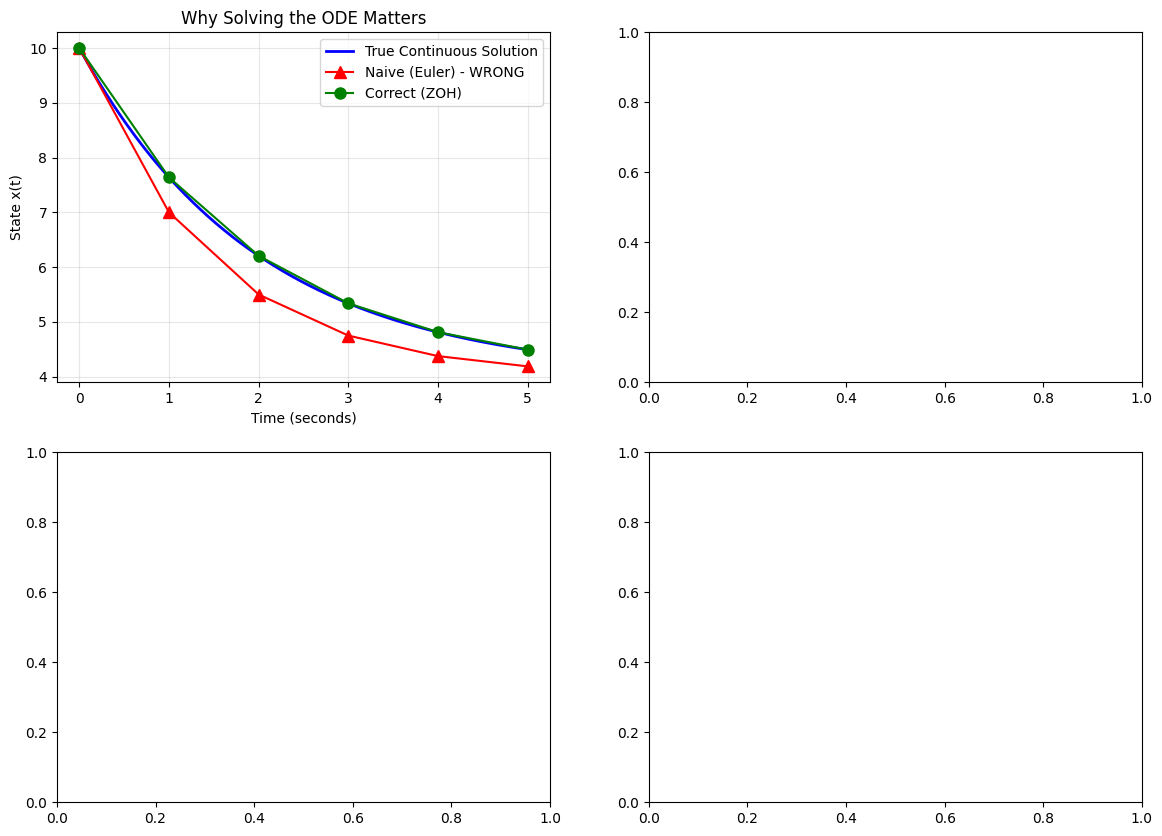

WRONG APPROACH: Naive Discretization
Step 1: x = 7.000
Step 2: x = 5.500
Step 3: x = 4.750
Step 4: x = 4.375
Step 5: x = 4.188

CORRECT APPROACH: Solving the Differential Equation

We need to solve: dx/dt = Ax + Bu
This is a first-order linear ODE with constant coefficients.

Step 1: Homogeneous solution (u=0)
   dx/dt = Ax
   Solution: x_h(t) = e^(At) * x(0)

Step 2: Particular solution (variation of parameters)
   Full solution: x(t) = e^(At)*x(0) + ∫[0,t] e^(A(t-τ))*B*u(τ) dτ

Step 3: Apply ZOH (u is constant over [0,Δ])
   x(Δ) = e^(AΔ)*x(0) + (∫[0,Δ] e^(As) ds)*B*u
   x(Δ) = e^(AΔ)*x(0) + A^(-1)*(e^(AΔ) - 1)*B*u

Discretized system:
A_d = e^(AΔ) = e^(-0.5*1.0) = 0.607
B_d = (e^(AΔ)-1)/A * B = 1.574
Step 1: x = 7.639
Step 2: x = 6.207
Step 3: x = 5.339
Step 4: x = 4.812
Step 5: x = 4.493


IndexError: index 1000 is out of bounds for axis 0 with size 1000

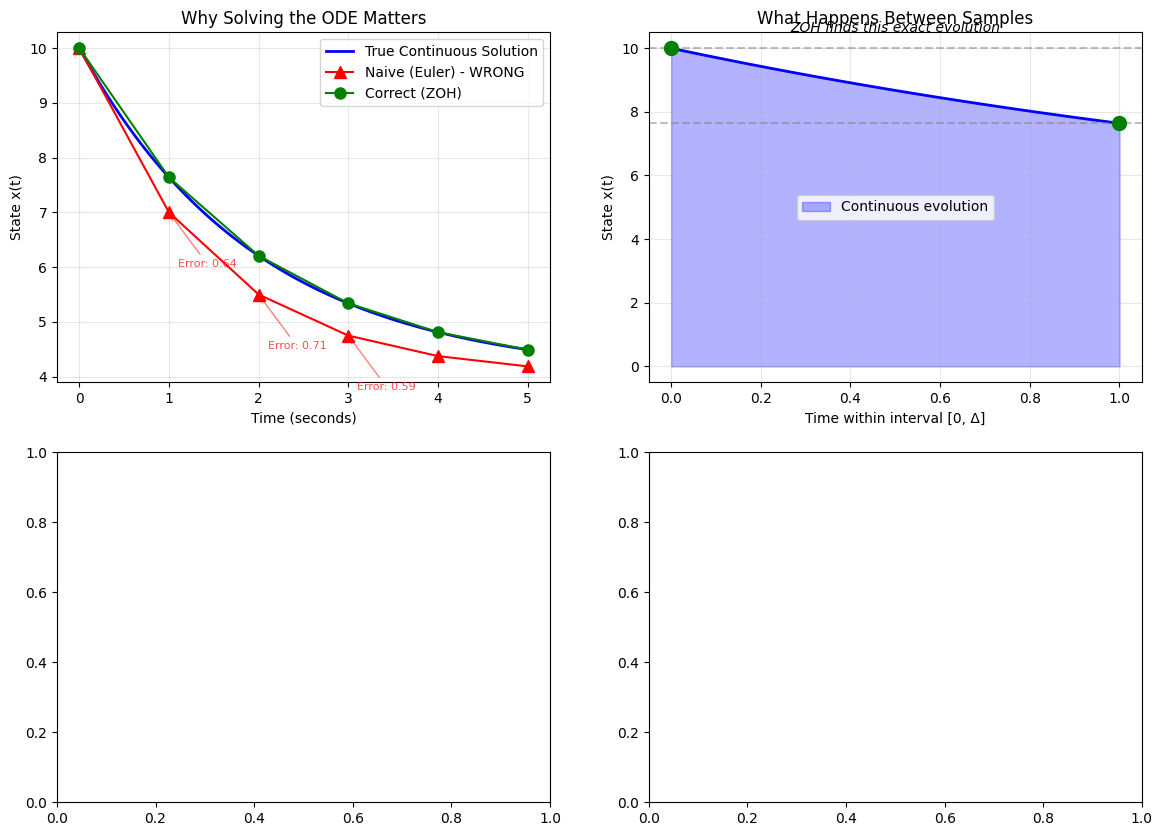